# Resnet18 CIFAR-10

Quantize train resnet18 without PACT

In [1]:
NOQUANT_TRAIN = False
n_epochs = 200
batches = 1024

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt
#import network.resnet_orig as resnet

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 32

In [3]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [4]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [5]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

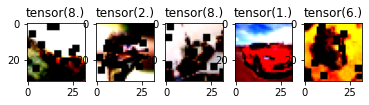

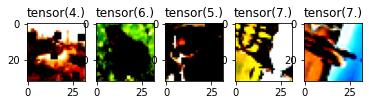

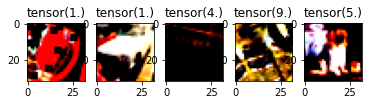

In [6]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [7]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [8]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batches, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batches, shuffle=False,
    num_workers=8, pin_memory=True)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
from pact_utils import QuantizedLinear, QuantizedConv2d, PGConv2d


def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = QuantizedConv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, wbits=k, abits=k)
        self.bn1 = nn.BatchNorm2d(planes)
        # self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = QuantizedConv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, wbits=k, abits=k)
        self.bn2 = nn.BatchNorm2d(planes)
        
        if stride != 1 or in_planes != planes:
              # original resnet shortcut
              self.shortcut = nn.Sequential(
                    # nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    QuantizedConv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False, wbits=k, abits=k),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # Relu is implemented as the input of conv2d
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.k = K

        self.conv1 = QuantizedConv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False, abits=8, wbits=8)
        self.bn1 = nn.BatchNorm2d(32)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2, expansion=1)

        # self.linear = nn.Linear(64, num_classes)
        self.linear = QuantizedLinear(128, num_classes, abits=8, wbits=8)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 3, 3], K=k)

In [10]:
net = resnet20(8)

bit width: 8


# Train with quantization

In [15]:
from timm.scheduler import CosineLRScheduler

for k in range(6,7):
    net = resnet20(k=k)

    model = net.cuda()
    mixup = False

    # Track experiment with wandb
    import wandb
    watermark = "resnet20_quantize_k{}".format(k)

    # mess with wandb
    wandb.init(project="quantize_resnet", name=watermark)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    # optimizer for pact
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                momentum=0.9,
                                weight_decay=0.0002)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    scheduler = CosineLRScheduler(optimizer, t_initial=n_epochs, lr_min=1e-6, 
                          warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

    best_prec1 = 0
    os.makedirs("models", exist_ok=True)

    for epoch in range(n_epochs):
        scheduler.step(epoch)
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)         

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

bit width: 6


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▃███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
prec,▁▃▅▅▅▆▇▇▇▇▇▇▇▇▇▇████████████████████████
train_loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
lr,1e-05
prec,85.39
train_loss,0.43375
val_loss,0.48321


current lr 1.00000e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [0][0/40]	Time 1.523 (1.523)	Data 1.460 (1.460)	Loss 3.9734 (3.9734)	Prec@1 11.328 (11.328)
Test: [0/10]	Time 0.693 (0.693)	Loss 3.6211 (3.6211)	Prec@1 9.668 (9.668)
 * Prec@1 9.860
alpha1 9.999961853027344
Best prec1 :  9.85999997406006
current lr 3.34000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [1][0/40]	Time 1.257 (1.257)	Data 1.194 (1.194)	Loss 4.0353 (4.0353)	Prec@1 8.496 (8.496)
Test: [0/10]	Time 0.694 (0.694)	Loss 1.8215 (1.8215)	Prec@1 32.715 (32.715)
 * Prec@1 33.080
alpha1 9.986610412597656
Best prec1 :  33.08000000915527
current lr 6.67000e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [2][0/40]	Time 1.273 (1.273)	Data 1.210 (1.210)	Loss 2.1069 (2.1069)	Prec@1 29.688 (29.688)
Test: [0/10]	Time 0.793 (0.793)	Loss 1.6475 (1.6475)	Prec@1 41.113 (41.113)
 * Prec@1 40.800
alpha1 9.959967613220215
Best prec1 :  40.799999938964845
current lr 1.00000e-03


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [3][0/40]	Time 1.223 (1.223)	Data 1.159 (1.159)	Loss 1.9917 (1.9917)	Prec@1 33.301 (33.301)
Test: [0/10]	Time 0.808 (0.808)	Loss 1.7253 (1.7253)	Prec@1 38.672 (38.672)
 * Prec@1 39.310
alpha1 9.920103073120117
Best prec1 :  40.799999938964845
current lr 9.99938e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [4][0/40]	Time 1.280 (1.280)	Data 1.217 (1.217)	Loss 1.9341 (1.9341)	Prec@1 37.500 (37.500)
Test: [0/10]	Time 0.699 (0.699)	Loss 1.5041 (1.5041)	Prec@1 45.312 (45.312)
 * Prec@1 46.070
alpha1 9.880339622497559
Best prec1 :  46.06999989624023
current lr 9.99754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [5][0/40]	Time 1.096 (1.096)	Data 1.034 (1.034)	Loss 1.7611 (1.7611)	Prec@1 43.164 (43.164)
Test: [0/10]	Time 0.699 (0.699)	Loss 1.4005 (1.4005)	Prec@1 50.684 (50.684)
 * Prec@1 52.020
alpha1 9.840672492980957
Best prec1 :  52.02000009765625
current lr 9.99445e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [6][0/40]	Time 1.544 (1.544)	Data 1.481 (1.481)	Loss 1.6295 (1.6295)	Prec@1 49.121 (49.121)
Test: [0/10]	Time 0.786 (0.786)	Loss 1.3119 (1.3119)	Prec@1 53.125 (53.125)
 * Prec@1 53.650
alpha1 9.801104545593262
Best prec1 :  53.649999871826175
current lr 9.99014e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [7][0/40]	Time 1.417 (1.417)	Data 1.354 (1.354)	Loss 1.6984 (1.6984)	Prec@1 46.777 (46.777)
Test: [0/10]	Time 0.810 (0.810)	Loss 1.3673 (1.3673)	Prec@1 49.316 (49.316)
 * Prec@1 51.800
alpha1 9.761632919311523
Best prec1 :  53.649999871826175
current lr 9.98460e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [8][0/40]	Time 1.488 (1.488)	Data 1.421 (1.421)	Loss 1.6996 (1.6996)	Prec@1 46.387 (46.387)
Test: [0/10]	Time 0.694 (0.694)	Loss 1.3575 (1.3575)	Prec@1 52.441 (52.441)
 * Prec@1 51.060
alpha1 9.722261428833008
Best prec1 :  53.649999871826175
current lr 9.97783e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [9][0/40]	Time 1.504 (1.504)	Data 1.442 (1.442)	Loss 1.5970 (1.5970)	Prec@1 50.195 (50.195)
Test: [0/10]	Time 0.719 (0.719)	Loss 1.2081 (1.2081)	Prec@1 55.469 (55.469)
 * Prec@1 56.070
alpha1 9.682992935180664
Best prec1 :  56.069999981689456
current lr 9.96983e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [10][0/40]	Time 1.514 (1.514)	Data 1.451 (1.451)	Loss 1.5946 (1.5946)	Prec@1 48.535 (48.535)
Test: [0/10]	Time 0.794 (0.794)	Loss 1.1400 (1.1400)	Prec@1 61.133 (61.133)
 * Prec@1 59.120
alpha1 9.643830299377441
Best prec1 :  59.119999932861326
current lr 9.96061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [11][0/40]	Time 1.460 (1.460)	Data 1.394 (1.394)	Loss 1.5208 (1.5208)	Prec@1 51.660 (51.660)
Test: [0/10]	Time 0.731 (0.731)	Loss 1.1094 (1.1094)	Prec@1 61.523 (61.523)
 * Prec@1 60.340
alpha1 9.604776382446289
Best prec1 :  60.33999987182617
current lr 9.95017e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [12][0/40]	Time 1.233 (1.233)	Data 1.171 (1.171)	Loss 1.5104 (1.5104)	Prec@1 51.953 (51.953)
Test: [0/10]	Time 0.764 (0.764)	Loss 1.1120 (1.1120)	Prec@1 61.719 (61.719)
 * Prec@1 60.040
alpha1 9.565834045410156
Best prec1 :  60.33999987182617
current lr 9.93850e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [13][0/40]	Time 1.571 (1.571)	Data 1.509 (1.509)	Loss 1.5477 (1.5477)	Prec@1 51.074 (51.074)
Test: [0/10]	Time 0.769 (0.769)	Loss 1.0533 (1.0533)	Prec@1 63.281 (63.281)
 * Prec@1 61.900
alpha1 9.527007102966309
Best prec1 :  61.89999984130859
current lr 9.92562e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [14][0/40]	Time 1.557 (1.557)	Data 1.493 (1.493)	Loss 1.3481 (1.3481)	Prec@1 59.570 (59.570)
Test: [0/10]	Time 0.808 (0.808)	Loss 1.0471 (1.0471)	Prec@1 63.867 (63.867)
 * Prec@1 62.010
alpha1 9.488299369812012
Best prec1 :  62.00999990844726
current lr 9.91152e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [15][0/40]	Time 1.231 (1.231)	Data 1.164 (1.164)	Loss 1.4705 (1.4705)	Prec@1 53.906 (53.906)
Test: [0/10]	Time 0.999 (0.999)	Loss 1.0699 (1.0699)	Prec@1 62.500 (62.500)
 * Prec@1 61.890
alpha1 9.449712753295898
Best prec1 :  62.00999990844726
current lr 9.89622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [16][0/40]	Time 1.587 (1.587)	Data 1.524 (1.524)	Loss 1.4521 (1.4521)	Prec@1 56.934 (56.934)
Test: [0/10]	Time 1.076 (1.076)	Loss 1.0124 (1.0124)	Prec@1 64.844 (64.844)
 * Prec@1 63.860
alpha1 9.411249160766602
Best prec1 :  63.86000007324219
current lr 9.87970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [17][0/40]	Time 1.442 (1.442)	Data 1.374 (1.374)	Loss 1.4135 (1.4135)	Prec@1 57.617 (57.617)
Test: [0/10]	Time 1.031 (1.031)	Loss 0.9835 (0.9835)	Prec@1 64.062 (64.062)
 * Prec@1 63.870
alpha1 9.372915267944336
Best prec1 :  63.8700000793457
current lr 9.86199e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [18][0/40]	Time 1.550 (1.550)	Data 1.488 (1.488)	Loss 1.4056 (1.4056)	Prec@1 56.738 (56.738)
Test: [0/10]	Time 0.730 (0.730)	Loss 0.9747 (0.9747)	Prec@1 66.992 (66.992)
 * Prec@1 64.940
alpha1 9.334712028503418
Best prec1 :  64.94000007324219
current lr 9.84307e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [19][0/40]	Time 1.213 (1.213)	Data 1.148 (1.148)	Loss 1.3534 (1.3534)	Prec@1 56.445 (56.445)
Test: [0/10]	Time 0.836 (0.836)	Loss 0.9299 (0.9299)	Prec@1 64.941 (64.941)
 * Prec@1 65.090
alpha1 9.296646118164062
Best prec1 :  65.08999991455079
current lr 9.82296e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [20][0/40]	Time 1.531 (1.531)	Data 1.469 (1.469)	Loss 1.3089 (1.3089)	Prec@1 60.059 (60.059)
Test: [0/10]	Time 0.816 (0.816)	Loss 0.9308 (0.9308)	Prec@1 68.262 (68.262)
 * Prec@1 66.620
alpha1 9.25871467590332
Best prec1 :  66.61999986572266
current lr 9.80167e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [21][0/40]	Time 1.330 (1.330)	Data 1.267 (1.267)	Loss 1.3013 (1.3013)	Prec@1 59.082 (59.082)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.9413 (0.9413)	Prec@1 65.625 (65.625)
 * Prec@1 64.520
alpha1 9.220929145812988
Best prec1 :  66.61999986572266
current lr 9.77919e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [22][0/40]	Time 1.245 (1.245)	Data 1.183 (1.183)	Loss 1.2730 (1.2730)	Prec@1 59.668 (59.668)
Test: [0/10]	Time 0.825 (0.825)	Loss 0.8822 (0.8822)	Prec@1 68.750 (68.750)
 * Prec@1 68.320
alpha1 9.183290481567383
Best prec1 :  68.31999974365235
current lr 9.75553e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [23][0/40]	Time 1.501 (1.501)	Data 1.436 (1.436)	Loss 1.3155 (1.3155)	Prec@1 59.082 (59.082)
Test: [0/10]	Time 0.808 (0.808)	Loss 0.8826 (0.8826)	Prec@1 69.141 (69.141)
 * Prec@1 67.840
alpha1 9.145798683166504
Best prec1 :  68.31999974365235
current lr 9.73070e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [24][0/40]	Time 1.230 (1.230)	Data 1.167 (1.167)	Loss 1.2988 (1.2988)	Prec@1 59.082 (59.082)
Test: [0/10]	Time 0.818 (0.818)	Loss 0.8677 (0.8677)	Prec@1 70.312 (70.312)
 * Prec@1 68.240
alpha1 9.108458518981934
Best prec1 :  68.31999974365235
current lr 9.70470e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [25][0/40]	Time 1.475 (1.475)	Data 1.409 (1.409)	Loss 1.2428 (1.2428)	Prec@1 61.914 (61.914)
Test: [0/10]	Time 0.830 (0.830)	Loss 0.8910 (0.8910)	Prec@1 69.922 (69.922)
 * Prec@1 68.010
alpha1 9.071272850036621
Best prec1 :  68.31999974365235
current lr 9.67754e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [26][0/40]	Time 1.573 (1.573)	Data 1.511 (1.511)	Loss 1.1861 (1.1861)	Prec@1 65.332 (65.332)
Test: [0/10]	Time 0.752 (0.752)	Loss 0.8618 (0.8618)	Prec@1 71.094 (71.094)
 * Prec@1 69.070
alpha1 9.034245491027832
Best prec1 :  69.06999971923828
current lr 9.64923e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [27][0/40]	Time 1.218 (1.218)	Data 1.152 (1.152)	Loss 1.2540 (1.2540)	Prec@1 62.012 (62.012)
Test: [0/10]	Time 0.702 (0.702)	Loss 0.8465 (0.8465)	Prec@1 70.703 (70.703)
 * Prec@1 69.290
alpha1 8.997376441955566
Best prec1 :  69.28999978027343
current lr 9.61978e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [28][0/40]	Time 1.307 (1.307)	Data 1.245 (1.245)	Loss 1.2008 (1.2008)	Prec@1 63.965 (63.965)
Test: [0/10]	Time 0.697 (0.697)	Loss 0.7978 (0.7978)	Prec@1 73.828 (73.828)
 * Prec@1 71.080
alpha1 8.960668563842773
Best prec1 :  71.08000010986328
current lr 9.58918e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [29][0/40]	Time 1.389 (1.389)	Data 1.324 (1.324)	Loss 1.1604 (1.1604)	Prec@1 63.477 (63.477)
Test: [0/10]	Time 0.724 (0.724)	Loss 0.8437 (0.8437)	Prec@1 72.070 (72.070)
 * Prec@1 69.130
alpha1 8.92413330078125
Best prec1 :  71.08000010986328
current lr 9.55746e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [30][0/40]	Time 1.482 (1.482)	Data 1.420 (1.420)	Loss 1.1695 (1.1695)	Prec@1 63.867 (63.867)
Test: [0/10]	Time 0.761 (0.761)	Loss 0.7882 (0.7882)	Prec@1 71.973 (71.973)
 * Prec@1 70.020
alpha1 8.887763977050781
Best prec1 :  71.08000010986328
current lr 9.52461e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [31][0/40]	Time 1.219 (1.219)	Data 1.153 (1.153)	Loss 1.1660 (1.1660)	Prec@1 64.941 (64.941)
Test: [0/10]	Time 0.729 (0.729)	Loss 0.7858 (0.7858)	Prec@1 73.340 (73.340)
 * Prec@1 70.380
alpha1 8.851572036743164
Best prec1 :  71.08000010986328
current lr 9.49065e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [32][0/40]	Time 1.320 (1.320)	Data 1.256 (1.256)	Loss 1.1414 (1.1414)	Prec@1 65.723 (65.723)
Test: [0/10]	Time 0.732 (0.732)	Loss 0.7716 (0.7716)	Prec@1 72.852 (72.852)
 * Prec@1 72.190
alpha1 8.8155517578125
Best prec1 :  72.1899999267578
current lr 9.45558e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [33][0/40]	Time 1.399 (1.399)	Data 1.336 (1.336)	Loss 1.1471 (1.1471)	Prec@1 64.941 (64.941)
Test: [0/10]	Time 0.719 (0.719)	Loss 0.7610 (0.7610)	Prec@1 73.926 (73.926)
 * Prec@1 70.540
alpha1 8.779711723327637
Best prec1 :  72.1899999267578
current lr 9.41941e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [34][0/40]	Time 1.186 (1.186)	Data 1.123 (1.123)	Loss 1.1542 (1.1542)	Prec@1 65.332 (65.332)
Test: [0/10]	Time 0.844 (0.844)	Loss 0.7473 (0.7473)	Prec@1 74.512 (74.512)
 * Prec@1 71.870
alpha1 8.744054794311523
Best prec1 :  72.1899999267578
current lr 9.38215e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [35][0/40]	Time 1.484 (1.484)	Data 1.421 (1.421)	Loss 1.0911 (1.0911)	Prec@1 65.625 (65.625)
Test: [0/10]	Time 0.700 (0.700)	Loss 0.7495 (0.7495)	Prec@1 73.047 (73.047)
 * Prec@1 71.820
alpha1 8.708582878112793
Best prec1 :  72.1899999267578
current lr 9.34381e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [36][0/40]	Time 1.547 (1.547)	Data 1.484 (1.484)	Loss 1.1126 (1.1126)	Prec@1 64.551 (64.551)
Test: [0/10]	Time 0.725 (0.725)	Loss 0.7171 (0.7171)	Prec@1 75.195 (75.195)
 * Prec@1 72.910
alpha1 8.673295974731445
Best prec1 :  72.91000004882812
current lr 9.30441e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [37][0/40]	Time 1.304 (1.304)	Data 1.239 (1.239)	Loss 1.0733 (1.0733)	Prec@1 67.383 (67.383)
Test: [0/10]	Time 0.743 (0.743)	Loss 0.7172 (0.7172)	Prec@1 75.879 (75.879)
 * Prec@1 73.920
alpha1 8.638197898864746
Best prec1 :  73.91999996337891
current lr 9.26394e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [38][0/40]	Time 1.250 (1.250)	Data 1.185 (1.185)	Loss 1.1819 (1.1819)	Prec@1 61.914 (61.914)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.7372 (0.7372)	Prec@1 74.805 (74.805)
 * Prec@1 72.590
alpha1 8.603294372558594
Best prec1 :  73.91999996337891
current lr 9.22242e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [39][0/40]	Time 1.195 (1.195)	Data 1.132 (1.132)	Loss 1.0517 (1.0517)	Prec@1 68.359 (68.359)
Test: [0/10]	Time 0.705 (0.705)	Loss 0.7023 (0.7023)	Prec@1 75.488 (75.488)
 * Prec@1 74.450
alpha1 8.568586349487305
Best prec1 :  74.44999968261719
current lr 9.17986e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [40][0/40]	Time 1.515 (1.515)	Data 1.452 (1.452)	Loss 1.1309 (1.1309)	Prec@1 65.820 (65.820)
Test: [0/10]	Time 0.708 (0.708)	Loss 0.7275 (0.7275)	Prec@1 74.902 (74.902)
 * Prec@1 73.710
alpha1 8.534075736999512
Best prec1 :  74.44999968261719
current lr 9.13627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [41][0/40]	Time 1.425 (1.425)	Data 1.359 (1.359)	Loss 1.0595 (1.0595)	Prec@1 68.555 (68.555)
Test: [0/10]	Time 0.804 (0.804)	Loss 0.6775 (0.6775)	Prec@1 77.246 (77.246)
 * Prec@1 74.510
alpha1 8.49976634979248
Best prec1 :  74.50999968261719
current lr 9.09166e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [42][0/40]	Time 1.191 (1.191)	Data 1.128 (1.128)	Loss 1.0986 (1.0986)	Prec@1 65.430 (65.430)
Test: [0/10]	Time 0.819 (0.819)	Loss 0.6983 (0.6983)	Prec@1 76.172 (76.172)
 * Prec@1 74.930
alpha1 8.46566104888916
Best prec1 :  74.93
current lr 9.04604e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [43][0/40]	Time 1.518 (1.518)	Data 1.454 (1.454)	Loss 1.0614 (1.0614)	Prec@1 66.504 (66.504)
Test: [0/10]	Time 0.822 (0.822)	Loss 0.6622 (0.6622)	Prec@1 77.637 (77.637)
 * Prec@1 75.130
alpha1 8.43175983428955
Best prec1 :  75.1300001586914
current lr 8.99942e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [44][0/40]	Time 1.280 (1.280)	Data 1.217 (1.217)	Loss 0.9853 (0.9853)	Prec@1 70.605 (70.605)
Test: [0/10]	Time 0.718 (0.718)	Loss 0.7034 (0.7034)	Prec@1 76.562 (76.562)
 * Prec@1 74.260
alpha1 8.398069381713867
Best prec1 :  75.1300001586914
current lr 8.95182e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [45][0/40]	Time 1.304 (1.304)	Data 1.240 (1.240)	Loss 1.0828 (1.0828)	Prec@1 66.504 (66.504)
Test: [0/10]	Time 0.749 (0.749)	Loss 0.6765 (0.6765)	Prec@1 77.930 (77.930)
 * Prec@1 74.700
alpha1 8.364585876464844
Best prec1 :  75.1300001586914
current lr 8.90325e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [46][0/40]	Time 1.480 (1.480)	Data 1.415 (1.415)	Loss 1.0207 (1.0207)	Prec@1 68.457 (68.457)
Test: [0/10]	Time 0.720 (0.720)	Loss 0.6551 (0.6551)	Prec@1 77.734 (77.734)
 * Prec@1 75.580
alpha1 8.331320762634277
Best prec1 :  75.58000010986328
current lr 8.85371e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [47][0/40]	Time 1.226 (1.226)	Data 1.163 (1.163)	Loss 1.0093 (1.0093)	Prec@1 68.652 (68.652)
Test: [0/10]	Time 0.845 (0.845)	Loss 0.6804 (0.6804)	Prec@1 76.562 (76.562)
 * Prec@1 74.740
alpha1 8.29826831817627
Best prec1 :  75.58000010986328
current lr 8.80323e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [48][0/40]	Time 1.295 (1.295)	Data 1.232 (1.232)	Loss 0.9916 (0.9916)	Prec@1 69.922 (69.922)
Test: [0/10]	Time 0.730 (0.730)	Loss 0.6625 (0.6625)	Prec@1 75.684 (75.684)
 * Prec@1 75.630
alpha1 8.265429496765137
Best prec1 :  75.62999991455078
current lr 8.75180e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [49][0/40]	Time 1.539 (1.539)	Data 1.476 (1.476)	Loss 1.0357 (1.0357)	Prec@1 68.750 (68.750)
Test: [0/10]	Time 0.831 (0.831)	Loss 0.6572 (0.6572)	Prec@1 76.562 (76.562)
 * Prec@1 76.060
alpha1 8.232813835144043
Best prec1 :  76.05999985351562
current lr 8.69946e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [50][0/40]	Time 1.120 (1.120)	Data 1.057 (1.057)	Loss 1.0136 (1.0136)	Prec@1 69.336 (69.336)
Test: [0/10]	Time 0.714 (0.714)	Loss 0.6133 (0.6133)	Prec@1 78.516 (78.516)
 * Prec@1 75.910
alpha1 8.20042610168457
Best prec1 :  76.05999985351562
current lr 8.64620e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [51][0/40]	Time 1.250 (1.250)	Data 1.187 (1.187)	Loss 1.0069 (1.0069)	Prec@1 68.945 (68.945)
Test: [0/10]	Time 0.717 (0.717)	Loss 0.6539 (0.6539)	Prec@1 77.734 (77.734)
 * Prec@1 75.820
alpha1 8.168262481689453
Best prec1 :  76.05999985351562
current lr 8.59204e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [52][0/40]	Time 1.316 (1.316)	Data 1.253 (1.253)	Loss 0.9843 (0.9843)	Prec@1 70.215 (70.215)
Test: [0/10]	Time 0.718 (0.718)	Loss 0.6319 (0.6319)	Prec@1 79.297 (79.297)
 * Prec@1 76.450
alpha1 8.136324882507324
Best prec1 :  76.44999987792968
current lr 8.53700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [53][0/40]	Time 1.474 (1.474)	Data 1.405 (1.405)	Loss 1.0418 (1.0418)	Prec@1 67.969 (67.969)
Test: [0/10]	Time 0.728 (0.728)	Loss 0.5975 (0.5975)	Prec@1 81.250 (81.250)
 * Prec@1 77.280
alpha1 8.104616165161133
Best prec1 :  77.28000001220703
current lr 8.48108e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [54][0/40]	Time 1.466 (1.466)	Data 1.400 (1.400)	Loss 0.9856 (0.9856)	Prec@1 70.410 (70.410)
Test: [0/10]	Time 0.692 (0.692)	Loss 0.6322 (0.6322)	Prec@1 78.027 (78.027)
 * Prec@1 76.170
alpha1 8.073141098022461
Best prec1 :  77.28000001220703
current lr 8.42431e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [55][0/40]	Time 1.170 (1.170)	Data 1.106 (1.106)	Loss 0.9628 (0.9628)	Prec@1 70.020 (70.020)
Test: [0/10]	Time 0.844 (0.844)	Loss 0.6097 (0.6097)	Prec@1 80.371 (80.371)
 * Prec@1 77.270
alpha1 8.041898727416992
Best prec1 :  77.28000001220703
current lr 8.36670e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [56][0/40]	Time 1.205 (1.205)	Data 1.142 (1.142)	Loss 0.9699 (0.9699)	Prec@1 71.191 (71.191)
Test: [0/10]	Time 0.720 (0.720)	Loss 0.6390 (0.6390)	Prec@1 78.613 (78.613)
 * Prec@1 76.730
alpha1 8.010885238647461
Best prec1 :  77.28000001220703
current lr 8.30825e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [57][0/40]	Time 1.340 (1.340)	Data 1.274 (1.274)	Loss 0.9573 (0.9573)	Prec@1 70.801 (70.801)
Test: [0/10]	Time 0.710 (0.710)	Loss 0.6516 (0.6516)	Prec@1 77.832 (77.832)
 * Prec@1 75.850
alpha1 7.980109214782715
Best prec1 :  77.28000001220703
current lr 8.24899e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [58][0/40]	Time 1.394 (1.394)	Data 1.331 (1.331)	Loss 0.9419 (0.9419)	Prec@1 72.852 (72.852)
Test: [0/10]	Time 0.730 (0.730)	Loss 0.6476 (0.6476)	Prec@1 77.930 (77.930)
 * Prec@1 75.950
alpha1 7.9495720863342285
Best prec1 :  77.28000001220703
current lr 8.18893e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [59][0/40]	Time 1.243 (1.243)	Data 1.174 (1.174)	Loss 0.9549 (0.9549)	Prec@1 72.070 (72.070)
Test: [0/10]	Time 0.822 (0.822)	Loss 0.5880 (0.5880)	Prec@1 80.371 (80.371)
 * Prec@1 77.900
alpha1 7.919276237487793
Best prec1 :  77.89999976806641
current lr 8.12809e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [60][0/40]	Time 1.265 (1.265)	Data 1.203 (1.203)	Loss 0.9571 (0.9571)	Prec@1 70.312 (70.312)
Test: [0/10]	Time 0.726 (0.726)	Loss 0.6407 (0.6407)	Prec@1 78.223 (78.223)
 * Prec@1 76.220
alpha1 7.889222621917725
Best prec1 :  77.89999976806641
current lr 8.06647e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [61][0/40]	Time 1.222 (1.222)	Data 1.159 (1.159)	Loss 0.9011 (0.9011)	Prec@1 72.266 (72.266)
Test: [0/10]	Time 0.744 (0.744)	Loss 0.5644 (0.5644)	Prec@1 80.566 (80.566)
 * Prec@1 78.180
alpha1 7.859412670135498
Best prec1 :  78.17999979248047
current lr 8.00410e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [62][0/40]	Time 1.583 (1.583)	Data 1.520 (1.520)	Loss 0.8823 (0.8823)	Prec@1 74.512 (74.512)
Test: [0/10]	Time 0.703 (0.703)	Loss 0.6122 (0.6122)	Prec@1 78.125 (78.125)
 * Prec@1 76.500
alpha1 7.829848766326904
Best prec1 :  78.17999979248047
current lr 7.94099e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [63][0/40]	Time 1.255 (1.255)	Data 1.192 (1.192)	Loss 0.8821 (0.8821)	Prec@1 72.949 (72.949)
Test: [0/10]	Time 0.747 (0.747)	Loss 0.5433 (0.5433)	Prec@1 81.836 (81.836)
 * Prec@1 78.720
alpha1 7.800532817840576
Best prec1 :  78.72000017089844
current lr 7.87715e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [64][0/40]	Time 1.587 (1.587)	Data 1.524 (1.524)	Loss 0.9592 (0.9592)	Prec@1 71.289 (71.289)
Test: [0/10]	Time 0.741 (0.741)	Loss 0.5697 (0.5697)	Prec@1 80.176 (80.176)
 * Prec@1 78.170
alpha1 7.771466255187988
Best prec1 :  78.72000017089844
current lr 7.81261e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [65][0/40]	Time 1.187 (1.187)	Data 1.124 (1.124)	Loss 0.9024 (0.9024)	Prec@1 73.438 (73.438)
Test: [0/10]	Time 0.789 (0.789)	Loss 0.5699 (0.5699)	Prec@1 78.809 (78.809)
 * Prec@1 78.050
alpha1 7.742652416229248
Best prec1 :  78.72000017089844
current lr 7.74737e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [66][0/40]	Time 1.247 (1.247)	Data 1.183 (1.183)	Loss 0.9269 (0.9269)	Prec@1 73.145 (73.145)
Test: [0/10]	Time 0.716 (0.716)	Loss 0.5629 (0.5629)	Prec@1 80.371 (80.371)
 * Prec@1 78.050
alpha1 7.714094638824463
Best prec1 :  78.72000017089844
current lr 7.68145e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [67][0/40]	Time 1.576 (1.576)	Data 1.511 (1.511)	Loss 0.8856 (0.8856)	Prec@1 73.145 (73.145)
Test: [0/10]	Time 0.782 (0.782)	Loss 0.6059 (0.6059)	Prec@1 80.078 (80.078)
 * Prec@1 77.570
alpha1 7.685789585113525
Best prec1 :  78.72000017089844
current lr 7.61488e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [68][0/40]	Time 1.096 (1.096)	Data 1.033 (1.033)	Loss 0.9028 (0.9028)	Prec@1 73.047 (73.047)
Test: [0/10]	Time 0.758 (0.758)	Loss 0.5854 (0.5854)	Prec@1 79.102 (79.102)
 * Prec@1 78.570
alpha1 7.657740116119385
Best prec1 :  78.72000017089844
current lr 7.54766e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [69][0/40]	Time 1.573 (1.573)	Data 1.508 (1.508)	Loss 0.8754 (0.8754)	Prec@1 73.828 (73.828)
Test: [0/10]	Time 0.737 (0.737)	Loss 0.5775 (0.5775)	Prec@1 80.664 (80.664)
 * Prec@1 78.910
alpha1 7.629950046539307
Best prec1 :  78.9099996459961
current lr 7.47982e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [70][0/40]	Time 1.276 (1.276)	Data 1.214 (1.214)	Loss 0.8499 (0.8499)	Prec@1 74.512 (74.512)
Test: [0/10]	Time 0.819 (0.819)	Loss 0.6168 (0.6168)	Prec@1 79.297 (79.297)
 * Prec@1 77.740
alpha1 7.602419376373291
Best prec1 :  78.9099996459961
current lr 7.41136e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [71][0/40]	Time 1.501 (1.501)	Data 1.433 (1.433)	Loss 0.8677 (0.8677)	Prec@1 73.535 (73.535)
Test: [0/10]	Time 0.766 (0.766)	Loss 0.5742 (0.5742)	Prec@1 80.176 (80.176)
 * Prec@1 78.010
alpha1 7.575144290924072
Best prec1 :  78.9099996459961
current lr 7.34231e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [72][0/40]	Time 1.456 (1.456)	Data 1.393 (1.393)	Loss 0.8817 (0.8817)	Prec@1 73.926 (73.926)
Test: [0/10]	Time 0.764 (0.764)	Loss 0.5823 (0.5823)	Prec@1 80.078 (80.078)
 * Prec@1 77.910
alpha1 7.548136234283447
Best prec1 :  78.9099996459961
current lr 7.27268e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [73][0/40]	Time 1.310 (1.310)	Data 1.244 (1.244)	Loss 0.8436 (0.8436)	Prec@1 75.000 (75.000)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5663 (0.5663)	Prec@1 80.957 (80.957)
 * Prec@1 78.700
alpha1 7.521395206451416
Best prec1 :  78.9099996459961
current lr 7.20250e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [74][0/40]	Time 1.438 (1.438)	Data 1.375 (1.375)	Loss 0.7886 (0.7886)	Prec@1 75.000 (75.000)
Test: [0/10]	Time 0.816 (0.816)	Loss 0.5637 (0.5637)	Prec@1 80.859 (80.859)
 * Prec@1 78.530
alpha1 7.4949188232421875
Best prec1 :  78.9099996459961
current lr 7.13177e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [75][0/40]	Time 1.451 (1.451)	Data 1.389 (1.389)	Loss 0.8339 (0.8339)	Prec@1 75.781 (75.781)
Test: [0/10]	Time 0.822 (0.822)	Loss 0.5645 (0.5645)	Prec@1 79.492 (79.492)
 * Prec@1 78.860
alpha1 7.4687066078186035
Best prec1 :  78.9099996459961
current lr 7.06051e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [76][0/40]	Time 1.278 (1.278)	Data 1.215 (1.215)	Loss 0.8529 (0.8529)	Prec@1 74.023 (74.023)
Test: [0/10]	Time 0.805 (0.805)	Loss 0.5637 (0.5637)	Prec@1 81.250 (81.250)
 * Prec@1 79.600
alpha1 7.4427618980407715
Best prec1 :  79.59999974365235
current lr 6.98875e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [77][0/40]	Time 1.578 (1.578)	Data 1.515 (1.515)	Loss 0.8004 (0.8004)	Prec@1 74.219 (74.219)
Test: [0/10]	Time 0.813 (0.813)	Loss 0.5587 (0.5587)	Prec@1 81.152 (81.152)
 * Prec@1 79.320
alpha1 7.417088985443115
Best prec1 :  79.59999974365235
current lr 6.91650e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [78][0/40]	Time 1.596 (1.596)	Data 1.531 (1.531)	Loss 0.7990 (0.7990)	Prec@1 75.586 (75.586)
Test: [0/10]	Time 0.825 (0.825)	Loss 0.5567 (0.5567)	Prec@1 81.250 (81.250)
 * Prec@1 78.860
alpha1 7.391683101654053
Best prec1 :  79.59999974365235
current lr 6.84378e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [79][0/40]	Time 1.317 (1.317)	Data 1.252 (1.252)	Loss 0.8384 (0.8384)	Prec@1 74.609 (74.609)
Test: [0/10]	Time 0.838 (0.838)	Loss 0.5767 (0.5767)	Prec@1 80.762 (80.762)
 * Prec@1 79.070
alpha1 7.366544246673584
Best prec1 :  79.59999974365235
current lr 6.77061e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [80][0/40]	Time 1.292 (1.292)	Data 1.229 (1.229)	Loss 0.8016 (0.8016)	Prec@1 75.000 (75.000)
Test: [0/10]	Time 0.823 (0.823)	Loss 0.5582 (0.5582)	Prec@1 81.738 (81.738)
 * Prec@1 78.920
alpha1 7.341672420501709
Best prec1 :  79.59999974365235
current lr 6.69700e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [81][0/40]	Time 1.245 (1.245)	Data 1.180 (1.180)	Loss 0.8089 (0.8089)	Prec@1 75.098 (75.098)
Test: [0/10]	Time 0.811 (0.811)	Loss 0.5376 (0.5376)	Prec@1 81.152 (81.152)
 * Prec@1 79.620
alpha1 7.317067623138428
Best prec1 :  79.62000012207031
current lr 6.62297e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [82][0/40]	Time 1.409 (1.409)	Data 1.346 (1.346)	Loss 0.7971 (0.7971)	Prec@1 76.562 (76.562)
Test: [0/10]	Time 0.784 (0.784)	Loss 0.5805 (0.5805)	Prec@1 80.859 (80.859)
 * Prec@1 79.160
alpha1 7.292748928070068
Best prec1 :  79.62000012207031
current lr 6.54854e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [83][0/40]	Time 1.233 (1.233)	Data 1.167 (1.167)	Loss 0.8181 (0.8181)	Prec@1 74.316 (74.316)
Test: [0/10]	Time 0.825 (0.825)	Loss 0.5643 (0.5643)	Prec@1 80.859 (80.859)
 * Prec@1 79.710
alpha1 7.268697261810303
Best prec1 :  79.70999970703124
current lr 6.47373e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [84][0/40]	Time 1.424 (1.424)	Data 1.358 (1.358)	Loss 0.7734 (0.7734)	Prec@1 75.977 (75.977)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.5525 (0.5525)	Prec@1 81.934 (81.934)
 * Prec@1 79.370
alpha1 7.244931697845459
Best prec1 :  79.70999970703124
current lr 6.39856e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [85][0/40]	Time 1.479 (1.479)	Data 1.409 (1.409)	Loss 0.7458 (0.7458)	Prec@1 77.832 (77.832)
Test: [0/10]	Time 0.784 (0.784)	Loss 0.5504 (0.5504)	Prec@1 81.543 (81.543)
 * Prec@1 79.620
alpha1 7.221433162689209
Best prec1 :  79.70999970703124
current lr 6.32305e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [86][0/40]	Time 1.473 (1.473)	Data 1.410 (1.410)	Loss 0.7779 (0.7779)	Prec@1 76.465 (76.465)
Test: [0/10]	Time 0.703 (0.703)	Loss 0.5327 (0.5327)	Prec@1 80.566 (80.566)
 * Prec@1 79.380
alpha1 7.198214530944824
Best prec1 :  79.70999970703124
current lr 6.24721e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [87][0/40]	Time 1.253 (1.253)	Data 1.190 (1.190)	Loss 0.7692 (0.7692)	Prec@1 77.246 (77.246)
Test: [0/10]	Time 0.759 (0.759)	Loss 0.5213 (0.5213)	Prec@1 82.617 (82.617)
 * Prec@1 80.150
alpha1 7.17526912689209
Best prec1 :  80.15000008544922
current lr 6.17106e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [88][0/40]	Time 1.391 (1.391)	Data 1.322 (1.322)	Loss 0.8604 (0.8604)	Prec@1 74.316 (74.316)
Test: [0/10]	Time 0.810 (0.810)	Loss 0.5344 (0.5344)	Prec@1 80.566 (80.566)
 * Prec@1 80.360
alpha1 7.152609825134277
Best prec1 :  80.3599998046875
current lr 6.09463e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [89][0/40]	Time 1.221 (1.221)	Data 1.158 (1.158)	Loss 0.8084 (0.8084)	Prec@1 75.684 (75.684)
Test: [0/10]	Time 0.786 (0.786)	Loss 0.5539 (0.5539)	Prec@1 81.250 (81.250)
 * Prec@1 80.110
alpha1 7.130217552185059
Best prec1 :  80.3599998046875
current lr 6.01792e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [90][0/40]	Time 1.256 (1.256)	Data 1.193 (1.193)	Loss 0.8187 (0.8187)	Prec@1 74.512 (74.512)
Test: [0/10]	Time 0.805 (0.805)	Loss 0.5822 (0.5822)	Prec@1 80.176 (80.176)
 * Prec@1 79.190
alpha1 7.108111381530762
Best prec1 :  80.3599998046875
current lr 5.94097e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [91][0/40]	Time 1.352 (1.352)	Data 1.289 (1.289)	Loss 0.7930 (0.7930)	Prec@1 75.293 (75.293)
Test: [0/10]	Time 0.762 (0.762)	Loss 0.5423 (0.5423)	Prec@1 82.031 (82.031)
 * Prec@1 79.980
alpha1 7.086284160614014
Best prec1 :  80.3599998046875
current lr 5.86379e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [92][0/40]	Time 1.534 (1.534)	Data 1.471 (1.471)	Loss 0.8066 (0.8066)	Prec@1 75.000 (75.000)
Test: [0/10]	Time 0.817 (0.817)	Loss 0.5584 (0.5584)	Prec@1 82.129 (82.129)
 * Prec@1 79.890
alpha1 7.064731121063232
Best prec1 :  80.3599998046875
current lr 5.78639e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [93][0/40]	Time 1.554 (1.554)	Data 1.491 (1.491)	Loss 0.7710 (0.7710)	Prec@1 75.488 (75.488)
Test: [0/10]	Time 0.842 (0.842)	Loss 0.5346 (0.5346)	Prec@1 81.836 (81.836)
 * Prec@1 80.080
alpha1 7.043464183807373
Best prec1 :  80.3599998046875
current lr 5.70880e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [94][0/40]	Time 1.474 (1.474)	Data 1.411 (1.411)	Loss 0.8207 (0.8207)	Prec@1 74.512 (74.512)
Test: [0/10]	Time 0.719 (0.719)	Loss 0.5643 (0.5643)	Prec@1 80.664 (80.664)
 * Prec@1 79.780
alpha1 7.0224833488464355
Best prec1 :  80.3599998046875
current lr 5.63104e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [95][0/40]	Time 1.260 (1.260)	Data 1.197 (1.197)	Loss 0.7439 (0.7439)	Prec@1 78.125 (78.125)
Test: [0/10]	Time 0.819 (0.819)	Loss 0.5588 (0.5588)	Prec@1 80.566 (80.566)
 * Prec@1 79.760
alpha1 7.001771450042725
Best prec1 :  80.3599998046875
current lr 5.55312e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [96][0/40]	Time 1.344 (1.344)	Data 1.282 (1.282)	Loss 0.7777 (0.7777)	Prec@1 76.465 (76.465)
Test: [0/10]	Time 0.794 (0.794)	Loss 0.5425 (0.5425)	Prec@1 80.957 (80.957)
 * Prec@1 80.370
alpha1 6.981343746185303
Best prec1 :  80.36999993896484
current lr 5.47507e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [97][0/40]	Time 1.527 (1.527)	Data 1.464 (1.464)	Loss 0.7734 (0.7734)	Prec@1 77.246 (77.246)
Test: [0/10]	Time 0.815 (0.815)	Loss 0.5243 (0.5243)	Prec@1 81.348 (81.348)
 * Prec@1 80.500
alpha1 6.961202144622803
Best prec1 :  80.49999990234375
current lr 5.39690e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [98][0/40]	Time 1.226 (1.226)	Data 1.154 (1.154)	Loss 0.7615 (0.7615)	Prec@1 75.879 (75.879)
Test: [0/10]	Time 0.781 (0.781)	Loss 0.5168 (0.5168)	Prec@1 82.129 (82.129)
 * Prec@1 80.640
alpha1 6.941346645355225
Best prec1 :  80.64000015869141
current lr 5.31864e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [99][0/40]	Time 1.364 (1.364)	Data 1.301 (1.301)	Loss 0.7376 (0.7376)	Prec@1 77.930 (77.930)
Test: [0/10]	Time 0.812 (0.812)	Loss 0.5288 (0.5288)	Prec@1 82.812 (82.812)
 * Prec@1 80.590
alpha1 6.9217681884765625
Best prec1 :  80.64000015869141
current lr 5.24030e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [100][0/40]	Time 1.197 (1.197)	Data 1.131 (1.131)	Loss 0.7898 (0.7898)	Prec@1 77.148 (77.148)
Test: [0/10]	Time 0.803 (0.803)	Loss 0.5187 (0.5187)	Prec@1 82.129 (82.129)
 * Prec@1 80.800
alpha1 6.9024658203125
Best prec1 :  80.7999998046875
current lr 5.16190e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [101][0/40]	Time 1.359 (1.359)	Data 1.294 (1.294)	Loss 0.7184 (0.7184)	Prec@1 77.832 (77.832)
Test: [0/10]	Time 0.748 (0.748)	Loss 0.5070 (0.5070)	Prec@1 81.641 (81.641)
 * Prec@1 80.240
alpha1 6.883449554443359
Best prec1 :  80.7999998046875
current lr 5.08346e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [102][0/40]	Time 1.538 (1.538)	Data 1.475 (1.475)	Loss 0.7239 (0.7239)	Prec@1 78.027 (78.027)
Test: [0/10]	Time 0.707 (0.707)	Loss 0.5438 (0.5438)	Prec@1 81.738 (81.738)
 * Prec@1 80.140
alpha1 6.864719390869141
Best prec1 :  80.7999998046875
current lr 5.00500e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [103][0/40]	Time 1.525 (1.525)	Data 1.460 (1.460)	Loss 0.7179 (0.7179)	Prec@1 77.539 (77.539)
Test: [0/10]	Time 0.802 (0.802)	Loss 0.5392 (0.5392)	Prec@1 80.957 (80.957)
 * Prec@1 80.110
alpha1 6.846275329589844
Best prec1 :  80.7999998046875
current lr 4.92654e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [104][0/40]	Time 1.535 (1.535)	Data 1.472 (1.472)	Loss 0.7379 (0.7379)	Prec@1 77.637 (77.637)
Test: [0/10]	Time 0.805 (0.805)	Loss 0.5385 (0.5385)	Prec@1 81.836 (81.836)
 * Prec@1 80.960
alpha1 6.82810640335083
Best prec1 :  80.95999987792969
current lr 4.84810e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [105][0/40]	Time 1.221 (1.221)	Data 1.158 (1.158)	Loss 0.6914 (0.6914)	Prec@1 79.395 (79.395)
Test: [0/10]	Time 0.716 (0.716)	Loss 0.5400 (0.5400)	Prec@1 80.957 (80.957)
 * Prec@1 80.160
alpha1 6.810215473175049
Best prec1 :  80.95999987792969
current lr 4.76970e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [106][0/40]	Time 1.252 (1.252)	Data 1.187 (1.187)	Loss 0.7615 (0.7615)	Prec@1 76.855 (76.855)
Test: [0/10]	Time 0.746 (0.746)	Loss 0.5269 (0.5269)	Prec@1 81.641 (81.641)
 * Prec@1 80.990
alpha1 6.7926106452941895
Best prec1 :  80.99000021972657
current lr 4.69136e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [107][0/40]	Time 1.535 (1.535)	Data 1.471 (1.471)	Loss 0.7251 (0.7251)	Prec@1 78.613 (78.613)
Test: [0/10]	Time 0.718 (0.718)	Loss 0.5308 (0.5308)	Prec@1 81.738 (81.738)
 * Prec@1 80.520
alpha1 6.775291919708252
Best prec1 :  80.99000021972657
current lr 4.61310e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [108][0/40]	Time 1.481 (1.481)	Data 1.415 (1.415)	Loss 0.7506 (0.7506)	Prec@1 77.832 (77.832)
Test: [0/10]	Time 0.708 (0.708)	Loss 0.5272 (0.5272)	Prec@1 81.543 (81.543)
 * Prec@1 80.910
alpha1 6.7582502365112305
Best prec1 :  80.99000021972657
current lr 4.53493e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [109][0/40]	Time 1.559 (1.559)	Data 1.495 (1.495)	Loss 0.6645 (0.6645)	Prec@1 80.078 (80.078)
Test: [0/10]	Time 0.813 (0.813)	Loss 0.5371 (0.5371)	Prec@1 82.324 (82.324)
 * Prec@1 80.730
alpha1 6.741484642028809
Best prec1 :  80.99000021972657
current lr 4.45688e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [110][0/40]	Time 1.208 (1.208)	Data 1.145 (1.145)	Loss 0.6980 (0.6980)	Prec@1 78.027 (78.027)
Test: [0/10]	Time 0.780 (0.780)	Loss 0.5104 (0.5104)	Prec@1 82.812 (82.812)
 * Prec@1 80.940
alpha1 6.725005149841309
Best prec1 :  80.99000021972657
current lr 4.37896e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [111][0/40]	Time 1.555 (1.555)	Data 1.492 (1.492)	Loss 0.6904 (0.6904)	Prec@1 79.590 (79.590)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.5233 (0.5233)	Prec@1 82.520 (82.520)
 * Prec@1 80.640
alpha1 6.708806037902832
Best prec1 :  80.99000021972657
current lr 4.30120e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [112][0/40]	Time 1.514 (1.514)	Data 1.451 (1.451)	Loss 0.7368 (0.7368)	Prec@1 77.539 (77.539)
Test: [0/10]	Time 0.815 (0.815)	Loss 0.5228 (0.5228)	Prec@1 82.227 (82.227)
 * Prec@1 80.840
alpha1 6.692879676818848
Best prec1 :  80.99000021972657
current lr 4.22361e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [113][0/40]	Time 1.489 (1.489)	Data 1.426 (1.426)	Loss 0.7291 (0.7291)	Prec@1 78.906 (78.906)
Test: [0/10]	Time 0.722 (0.722)	Loss 0.5467 (0.5467)	Prec@1 81.934 (81.934)
 * Prec@1 80.550
alpha1 6.677239418029785
Best prec1 :  80.99000021972657
current lr 4.14621e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [114][0/40]	Time 1.223 (1.223)	Data 1.160 (1.160)	Loss 0.6949 (0.6949)	Prec@1 79.590 (79.590)
Test: [0/10]	Time 0.789 (0.789)	Loss 0.5190 (0.5190)	Prec@1 81.934 (81.934)
 * Prec@1 80.980
alpha1 6.661871910095215
Best prec1 :  80.99000021972657
current lr 4.06903e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [115][0/40]	Time 1.200 (1.200)	Data 1.138 (1.138)	Loss 0.7115 (0.7115)	Prec@1 78.027 (78.027)
Test: [0/10]	Time 0.812 (0.812)	Loss 0.5463 (0.5463)	Prec@1 81.543 (81.543)
 * Prec@1 80.960
alpha1 6.646784782409668
Best prec1 :  80.99000021972657
current lr 3.99208e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [116][0/40]	Time 1.263 (1.263)	Data 1.200 (1.200)	Loss 0.7164 (0.7164)	Prec@1 78.809 (78.809)
Test: [0/10]	Time 0.812 (0.812)	Loss 0.5232 (0.5232)	Prec@1 83.105 (83.105)
 * Prec@1 81.010
alpha1 6.631972312927246
Best prec1 :  81.01000002441407
current lr 3.91537e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [117][0/40]	Time 1.231 (1.231)	Data 1.164 (1.164)	Loss 0.6756 (0.6756)	Prec@1 80.957 (80.957)
Test: [0/10]	Time 0.832 (0.832)	Loss 0.4861 (0.4861)	Prec@1 83.203 (83.203)
 * Prec@1 81.470
alpha1 6.617438316345215
Best prec1 :  81.47000021972656
current lr 3.83894e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [118][0/40]	Time 1.500 (1.500)	Data 1.438 (1.438)	Loss 0.6717 (0.6717)	Prec@1 79.688 (79.688)
Test: [0/10]	Time 0.847 (0.847)	Loss 0.5076 (0.5076)	Prec@1 82.520 (82.520)
 * Prec@1 81.240
alpha1 6.603173732757568
Best prec1 :  81.47000021972656
current lr 3.76279e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [119][0/40]	Time 1.573 (1.573)	Data 1.510 (1.510)	Loss 0.6673 (0.6673)	Prec@1 80.371 (80.371)
Test: [0/10]	Time 0.706 (0.706)	Loss 0.5122 (0.5122)	Prec@1 83.301 (83.301)
 * Prec@1 81.440
alpha1 6.58919095993042
Best prec1 :  81.47000021972656
current lr 3.68695e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [120][0/40]	Time 1.495 (1.495)	Data 1.432 (1.432)	Loss 0.6685 (0.6685)	Prec@1 80.176 (80.176)
Test: [0/10]	Time 0.722 (0.722)	Loss 0.5305 (0.5305)	Prec@1 81.738 (81.738)
 * Prec@1 80.690
alpha1 6.575477123260498
Best prec1 :  81.47000021972656
current lr 3.61144e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [121][0/40]	Time 1.527 (1.527)	Data 1.462 (1.462)	Loss 0.6777 (0.6777)	Prec@1 79.004 (79.004)
Test: [0/10]	Time 0.704 (0.704)	Loss 0.5147 (0.5147)	Prec@1 82.129 (82.129)
 * Prec@1 81.270
alpha1 6.56203031539917
Best prec1 :  81.47000021972656
current lr 3.53627e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [122][0/40]	Time 1.561 (1.561)	Data 1.496 (1.496)	Loss 0.6416 (0.6416)	Prec@1 80.078 (80.078)
Test: [0/10]	Time 0.780 (0.780)	Loss 0.5238 (0.5238)	Prec@1 83.008 (83.008)
 * Prec@1 80.830
alpha1 6.548858642578125
Best prec1 :  81.47000021972656
current lr 3.46146e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [123][0/40]	Time 1.253 (1.253)	Data 1.188 (1.188)	Loss 0.6401 (0.6401)	Prec@1 80.566 (80.566)
Test: [0/10]	Time 0.847 (0.847)	Loss 0.5348 (0.5348)	Prec@1 82.715 (82.715)
 * Prec@1 80.840
alpha1 6.5359601974487305
Best prec1 :  81.47000021972656
current lr 3.38703e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [124][0/40]	Time 1.110 (1.110)	Data 1.044 (1.044)	Loss 0.6715 (0.6715)	Prec@1 79.297 (79.297)
Test: [0/10]	Time 0.729 (0.729)	Loss 0.5214 (0.5214)	Prec@1 82.422 (82.422)
 * Prec@1 81.190
alpha1 6.523332118988037
Best prec1 :  81.47000021972656
current lr 3.31300e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [125][0/40]	Time 1.115 (1.115)	Data 1.046 (1.046)	Loss 0.6132 (0.6132)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.840 (0.840)	Loss 0.5363 (0.5363)	Prec@1 82.324 (82.324)
 * Prec@1 80.880
alpha1 6.510971546173096
Best prec1 :  81.47000021972656
current lr 3.23939e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [126][0/40]	Time 1.533 (1.533)	Data 1.470 (1.470)	Loss 0.6439 (0.6439)	Prec@1 80.859 (80.859)
Test: [0/10]	Time 0.742 (0.742)	Loss 0.5440 (0.5440)	Prec@1 81.836 (81.836)
 * Prec@1 81.020
alpha1 6.498875617980957
Best prec1 :  81.47000021972656
current lr 3.16622e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [127][0/40]	Time 1.439 (1.439)	Data 1.375 (1.375)	Loss 0.6972 (0.6972)	Prec@1 78.320 (78.320)
Test: [0/10]	Time 0.727 (0.727)	Loss 0.5246 (0.5246)	Prec@1 82.422 (82.422)
 * Prec@1 81.540
alpha1 6.48704195022583
Best prec1 :  81.54000015869141
current lr 3.09350e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [128][0/40]	Time 1.334 (1.334)	Data 1.271 (1.271)	Loss 0.6484 (0.6484)	Prec@1 80.566 (80.566)
Test: [0/10]	Time 0.767 (0.767)	Loss 0.5267 (0.5267)	Prec@1 81.934 (81.934)
 * Prec@1 80.890
alpha1 6.475466728210449
Best prec1 :  81.54000015869141
current lr 3.02125e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [129][0/40]	Time 1.597 (1.597)	Data 1.532 (1.532)	Loss 0.6639 (0.6639)	Prec@1 79.199 (79.199)
Test: [0/10]	Time 0.810 (0.810)	Loss 0.5402 (0.5402)	Prec@1 81.934 (81.934)
 * Prec@1 81.220
alpha1 6.464156150817871
Best prec1 :  81.54000015869141
current lr 2.94949e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [130][0/40]	Time 1.230 (1.230)	Data 1.166 (1.166)	Loss 0.6266 (0.6266)	Prec@1 81.348 (81.348)
Test: [0/10]	Time 0.760 (0.760)	Loss 0.5231 (0.5231)	Prec@1 82.422 (82.422)
 * Prec@1 81.790
alpha1 6.45311164855957
Best prec1 :  81.7900000366211
current lr 2.87823e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [131][0/40]	Time 1.152 (1.152)	Data 1.089 (1.089)	Loss 0.7054 (0.7054)	Prec@1 76.855 (76.855)
Test: [0/10]	Time 0.758 (0.758)	Loss 0.5193 (0.5193)	Prec@1 82.617 (82.617)
 * Prec@1 81.370
alpha1 6.442316055297852
Best prec1 :  81.7900000366211
current lr 2.80750e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [132][0/40]	Time 1.406 (1.406)	Data 1.343 (1.343)	Loss 0.6540 (0.6540)	Prec@1 79.883 (79.883)
Test: [0/10]	Time 0.715 (0.715)	Loss 0.5133 (0.5133)	Prec@1 83.105 (83.105)
 * Prec@1 81.310
alpha1 6.431787490844727
Best prec1 :  81.7900000366211
current lr 2.73732e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [133][0/40]	Time 1.383 (1.383)	Data 1.320 (1.320)	Loss 0.6300 (0.6300)	Prec@1 81.738 (81.738)
Test: [0/10]	Time 0.874 (0.874)	Loss 0.5265 (0.5265)	Prec@1 82.715 (82.715)
 * Prec@1 81.540
alpha1 6.421506881713867
Best prec1 :  81.7900000366211
current lr 2.66769e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [134][0/40]	Time 1.474 (1.474)	Data 1.407 (1.407)	Loss 0.6990 (0.6990)	Prec@1 78.711 (78.711)
Test: [0/10]	Time 0.818 (0.818)	Loss 0.5135 (0.5135)	Prec@1 83.984 (83.984)
 * Prec@1 81.510
alpha1 6.4114789962768555
Best prec1 :  81.7900000366211
current lr 2.59864e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [135][0/40]	Time 1.551 (1.551)	Data 1.486 (1.486)	Loss 0.6724 (0.6724)	Prec@1 79.395 (79.395)
Test: [0/10]	Time 0.727 (0.727)	Loss 0.5153 (0.5153)	Prec@1 82.520 (82.520)
 * Prec@1 81.460
alpha1 6.401708126068115
Best prec1 :  81.7900000366211
current lr 2.53018e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [136][0/40]	Time 1.248 (1.248)	Data 1.185 (1.185)	Loss 0.6368 (0.6368)	Prec@1 80.469 (80.469)
Test: [0/10]	Time 0.706 (0.706)	Loss 0.5293 (0.5293)	Prec@1 82.715 (82.715)
 * Prec@1 81.170
alpha1 6.3921895027160645
Best prec1 :  81.7900000366211
current lr 2.46234e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [137][0/40]	Time 1.224 (1.224)	Data 1.161 (1.161)	Loss 0.6284 (0.6284)	Prec@1 80.762 (80.762)
Test: [0/10]	Time 0.723 (0.723)	Loss 0.5123 (0.5123)	Prec@1 82.617 (82.617)
 * Prec@1 81.300
alpha1 6.382918357849121
Best prec1 :  81.7900000366211
current lr 2.39512e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [138][0/40]	Time 1.216 (1.216)	Data 1.150 (1.150)	Loss 0.6098 (0.6098)	Prec@1 82.422 (82.422)
Test: [0/10]	Time 0.713 (0.713)	Loss 0.5197 (0.5197)	Prec@1 83.008 (83.008)
 * Prec@1 81.570
alpha1 6.373889923095703
Best prec1 :  81.7900000366211
current lr 2.32855e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [139][0/40]	Time 1.574 (1.574)	Data 1.511 (1.511)	Loss 0.6952 (0.6952)	Prec@1 77.930 (77.930)
Test: [0/10]	Time 0.791 (0.791)	Loss 0.5129 (0.5129)	Prec@1 82.422 (82.422)
 * Prec@1 81.610
alpha1 6.365098476409912
Best prec1 :  81.7900000366211
current lr 2.26263e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [140][0/40]	Time 1.322 (1.322)	Data 1.254 (1.254)	Loss 0.6372 (0.6372)	Prec@1 80.957 (80.957)
Test: [0/10]	Time 0.751 (0.751)	Loss 0.5358 (0.5358)	Prec@1 82.910 (82.910)
 * Prec@1 81.540
alpha1 6.356553554534912
Best prec1 :  81.7900000366211
current lr 2.19739e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [141][0/40]	Time 1.232 (1.232)	Data 1.164 (1.164)	Loss 0.6033 (0.6033)	Prec@1 82.324 (82.324)
Test: [0/10]	Time 0.779 (0.779)	Loss 0.5182 (0.5182)	Prec@1 83.203 (83.203)
 * Prec@1 81.700
alpha1 6.348249435424805
Best prec1 :  81.7900000366211
current lr 2.13285e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [142][0/40]	Time 1.258 (1.258)	Data 1.193 (1.193)	Loss 0.6573 (0.6573)	Prec@1 80.762 (80.762)
Test: [0/10]	Time 0.718 (0.718)	Loss 0.5290 (0.5290)	Prec@1 82.324 (82.324)
 * Prec@1 81.560
alpha1 6.340181350708008
Best prec1 :  81.7900000366211
current lr 2.06901e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [143][0/40]	Time 1.548 (1.548)	Data 1.485 (1.485)	Loss 0.6267 (0.6267)	Prec@1 82.617 (82.617)
Test: [0/10]	Time 0.809 (0.809)	Loss 0.5116 (0.5116)	Prec@1 83.496 (83.496)
 * Prec@1 81.580
alpha1 6.332342147827148
Best prec1 :  81.7900000366211
current lr 2.00590e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [144][0/40]	Time 1.351 (1.351)	Data 1.288 (1.288)	Loss 0.5918 (0.5918)	Prec@1 82.422 (82.422)
Test: [0/10]	Time 0.726 (0.726)	Loss 0.5190 (0.5190)	Prec@1 82.324 (82.324)
 * Prec@1 81.350
alpha1 6.324740409851074
Best prec1 :  81.7900000366211
current lr 1.94353e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [145][0/40]	Time 1.232 (1.232)	Data 1.169 (1.169)	Loss 0.5836 (0.5836)	Prec@1 82.812 (82.812)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5122 (0.5122)	Prec@1 82.520 (82.520)
 * Prec@1 81.290
alpha1 6.317370891571045
Best prec1 :  81.7900000366211
current lr 1.88191e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [146][0/40]	Time 1.241 (1.241)	Data 1.175 (1.175)	Loss 0.5843 (0.5843)	Prec@1 81.934 (81.934)
Test: [0/10]	Time 0.832 (0.832)	Loss 0.5001 (0.5001)	Prec@1 83.594 (83.594)
 * Prec@1 81.470
alpha1 6.310225963592529
Best prec1 :  81.7900000366211
current lr 1.82107e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [147][0/40]	Time 1.515 (1.515)	Data 1.452 (1.452)	Loss 0.6360 (0.6360)	Prec@1 80.371 (80.371)
Test: [0/10]	Time 0.731 (0.731)	Loss 0.5104 (0.5104)	Prec@1 82.715 (82.715)
 * Prec@1 81.650
alpha1 6.30330228805542
Best prec1 :  81.7900000366211
current lr 1.76101e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [148][0/40]	Time 1.526 (1.526)	Data 1.463 (1.463)	Loss 0.6219 (0.6219)	Prec@1 82.129 (82.129)
Test: [0/10]	Time 0.811 (0.811)	Loss 0.5235 (0.5235)	Prec@1 82.715 (82.715)
 * Prec@1 81.350
alpha1 6.296607494354248
Best prec1 :  81.7900000366211
current lr 1.70175e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [149][0/40]	Time 1.280 (1.280)	Data 1.216 (1.216)	Loss 0.6179 (0.6179)	Prec@1 82.324 (82.324)
Test: [0/10]	Time 0.722 (0.722)	Loss 0.5132 (0.5132)	Prec@1 82.227 (82.227)
 * Prec@1 81.680
alpha1 6.290128231048584
Best prec1 :  81.7900000366211
current lr 1.64330e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [150][0/40]	Time 1.182 (1.182)	Data 1.119 (1.119)	Loss 0.5973 (0.5973)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.730 (0.730)	Loss 0.5115 (0.5115)	Prec@1 82.422 (82.422)
 * Prec@1 81.570
alpha1 6.283872127532959
Best prec1 :  81.7900000366211
current lr 1.58569e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [151][0/40]	Time 1.569 (1.569)	Data 1.506 (1.506)	Loss 0.6113 (0.6113)	Prec@1 81.934 (81.934)
Test: [0/10]	Time 0.717 (0.717)	Loss 0.5118 (0.5118)	Prec@1 83.398 (83.398)
 * Prec@1 81.770
alpha1 6.277825832366943
Best prec1 :  81.7900000366211
current lr 1.52892e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [152][0/40]	Time 1.223 (1.223)	Data 1.157 (1.157)	Loss 0.6389 (0.6389)	Prec@1 82.227 (82.227)
Test: [0/10]	Time 0.822 (0.822)	Loss 0.5197 (0.5197)	Prec@1 82.520 (82.520)
 * Prec@1 81.480
alpha1 6.271989345550537
Best prec1 :  81.7900000366211
current lr 1.47300e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [153][0/40]	Time 1.535 (1.535)	Data 1.472 (1.472)	Loss 0.6475 (0.6475)	Prec@1 80.762 (80.762)
Test: [0/10]	Time 0.718 (0.718)	Loss 0.5171 (0.5171)	Prec@1 82.910 (82.910)
 * Prec@1 81.830
alpha1 6.26636266708374
Best prec1 :  81.82999978027344
current lr 1.41796e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [154][0/40]	Time 1.587 (1.587)	Data 1.524 (1.524)	Loss 0.6293 (0.6293)	Prec@1 80.957 (80.957)
Test: [0/10]	Time 0.716 (0.716)	Loss 0.5064 (0.5064)	Prec@1 82.812 (82.812)
 * Prec@1 81.600
alpha1 6.260945796966553
Best prec1 :  81.82999978027344
current lr 1.36380e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [155][0/40]	Time 1.549 (1.549)	Data 1.484 (1.484)	Loss 0.5764 (0.5764)	Prec@1 83.301 (83.301)
Test: [0/10]	Time 0.723 (0.723)	Loss 0.5049 (0.5049)	Prec@1 83.105 (83.105)
 * Prec@1 81.860
alpha1 6.2557244300842285
Best prec1 :  81.85999987792968
current lr 1.31054e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [156][0/40]	Time 1.454 (1.454)	Data 1.391 (1.391)	Loss 0.6123 (0.6123)	Prec@1 82.715 (82.715)
Test: [0/10]	Time 0.795 (0.795)	Loss 0.5101 (0.5101)	Prec@1 83.105 (83.105)
 * Prec@1 81.750
alpha1 6.250708103179932
Best prec1 :  81.85999987792968
current lr 1.25820e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [157][0/40]	Time 1.563 (1.563)	Data 1.500 (1.500)	Loss 0.5515 (0.5515)	Prec@1 84.570 (84.570)
Test: [0/10]	Time 0.731 (0.731)	Loss 0.5131 (0.5131)	Prec@1 82.812 (82.812)
 * Prec@1 81.680
alpha1 6.245882511138916
Best prec1 :  81.85999987792968
current lr 1.20677e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [158][0/40]	Time 1.198 (1.198)	Data 1.130 (1.130)	Loss 0.6166 (0.6166)	Prec@1 83.594 (83.594)
Test: [0/10]	Time 0.733 (0.733)	Loss 0.4964 (0.4964)	Prec@1 82.910 (82.910)
 * Prec@1 81.760
alpha1 6.241247653961182
Best prec1 :  81.85999987792968
current lr 1.15629e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [159][0/40]	Time 1.228 (1.228)	Data 1.165 (1.165)	Loss 0.6413 (0.6413)	Prec@1 81.738 (81.738)
Test: [0/10]	Time 0.747 (0.747)	Loss 0.5039 (0.5039)	Prec@1 83.105 (83.105)
 * Prec@1 81.970
alpha1 6.2368035316467285
Best prec1 :  81.96999969482422
current lr 1.10675e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [160][0/40]	Time 1.557 (1.557)	Data 1.495 (1.495)	Loss 0.6148 (0.6148)	Prec@1 82.715 (82.715)
Test: [0/10]	Time 0.719 (0.719)	Loss 0.5005 (0.5005)	Prec@1 82.910 (82.910)
 * Prec@1 81.890
alpha1 6.232550144195557
Best prec1 :  81.96999969482422
current lr 1.05818e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [161][0/40]	Time 1.147 (1.147)	Data 1.083 (1.083)	Loss 0.5869 (0.5869)	Prec@1 81.934 (81.934)
Test: [0/10]	Time 0.765 (0.765)	Loss 0.5020 (0.5020)	Prec@1 82.910 (82.910)
 * Prec@1 81.890
alpha1 6.228487491607666
Best prec1 :  81.96999969482422
current lr 1.01058e-04


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [162][0/40]	Time 1.181 (1.181)	Data 1.118 (1.118)	Loss 0.5482 (0.5482)	Prec@1 83.105 (83.105)
Test: [0/10]	Time 0.824 (0.824)	Loss 0.5042 (0.5042)	Prec@1 82.812 (82.812)
 * Prec@1 81.880
alpha1 6.2245965003967285
Best prec1 :  81.96999969482422
current lr 9.63960e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [163][0/40]	Time 1.332 (1.332)	Data 1.269 (1.269)	Loss 0.6229 (0.6229)	Prec@1 80.957 (80.957)
Test: [0/10]	Time 0.792 (0.792)	Loss 0.5070 (0.5070)	Prec@1 83.594 (83.594)
 * Prec@1 81.840
alpha1 6.220877170562744
Best prec1 :  81.96999969482422
current lr 9.18342e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [164][0/40]	Time 1.213 (1.213)	Data 1.150 (1.150)	Loss 0.5936 (0.5936)	Prec@1 81.934 (81.934)
Test: [0/10]	Time 0.825 (0.825)	Loss 0.5032 (0.5032)	Prec@1 82.812 (82.812)
 * Prec@1 82.010
alpha1 6.217329502105713
Best prec1 :  82.00999978027343
current lr 8.73733e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [165][0/40]	Time 1.205 (1.205)	Data 1.140 (1.140)	Loss 0.5411 (0.5411)	Prec@1 84.766 (84.766)
Test: [0/10]	Time 0.801 (0.801)	Loss 0.5081 (0.5081)	Prec@1 83.203 (83.203)
 * Prec@1 81.840
alpha1 6.213953495025635
Best prec1 :  82.00999978027343
current lr 8.30142e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [166][0/40]	Time 1.292 (1.292)	Data 1.226 (1.226)	Loss 0.5905 (0.5905)	Prec@1 82.715 (82.715)
Test: [0/10]	Time 0.743 (0.743)	Loss 0.5044 (0.5044)	Prec@1 83.301 (83.301)
 * Prec@1 82.030
alpha1 6.21074914932251
Best prec1 :  82.02999997558594
current lr 7.87582e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [167][0/40]	Time 1.535 (1.535)	Data 1.472 (1.472)	Loss 0.6476 (0.6476)	Prec@1 80.176 (80.176)
Test: [0/10]	Time 0.817 (0.817)	Loss 0.5120 (0.5120)	Prec@1 83.203 (83.203)
 * Prec@1 81.730
alpha1 6.20769739151001
Best prec1 :  82.02999997558594
current lr 7.46062e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [168][0/40]	Time 1.504 (1.504)	Data 1.439 (1.439)	Loss 0.5607 (0.5607)	Prec@1 83.203 (83.203)
Test: [0/10]	Time 0.813 (0.813)	Loss 0.5127 (0.5127)	Prec@1 82.617 (82.617)
 * Prec@1 81.730
alpha1 6.204817295074463
Best prec1 :  82.02999997558594
current lr 7.05594e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [169][0/40]	Time 1.557 (1.557)	Data 1.493 (1.493)	Loss 0.5943 (0.5943)	Prec@1 83.008 (83.008)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.5172 (0.5172)	Prec@1 83.105 (83.105)
 * Prec@1 81.890
alpha1 6.202089786529541
Best prec1 :  82.02999997558594
current lr 6.66186e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [170][0/40]	Time 1.306 (1.306)	Data 1.240 (1.240)	Loss 0.6273 (0.6273)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.739 (0.739)	Loss 0.5221 (0.5221)	Prec@1 83.008 (83.008)
 * Prec@1 81.880
alpha1 6.199514865875244
Best prec1 :  82.02999997558594
current lr 6.27848e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [171][0/40]	Time 1.130 (1.130)	Data 1.066 (1.066)	Loss 0.5978 (0.5978)	Prec@1 81.250 (81.250)
Test: [0/10]	Time 0.824 (0.824)	Loss 0.5103 (0.5103)	Prec@1 83.496 (83.496)
 * Prec@1 81.990
alpha1 6.197073459625244
Best prec1 :  82.02999997558594
current lr 5.90591e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [172][0/40]	Time 1.294 (1.294)	Data 1.228 (1.228)	Loss 0.5963 (0.5963)	Prec@1 83.008 (83.008)
Test: [0/10]	Time 0.807 (0.807)	Loss 0.5131 (0.5131)	Prec@1 83.398 (83.398)
 * Prec@1 81.860
alpha1 6.194784641265869
Best prec1 :  82.02999997558594
current lr 5.54422e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [173][0/40]	Time 1.376 (1.376)	Data 1.313 (1.313)	Loss 0.6330 (0.6330)	Prec@1 80.371 (80.371)
Test: [0/10]	Time 0.831 (0.831)	Loss 0.5119 (0.5119)	Prec@1 82.227 (82.227)
 * Prec@1 81.690
alpha1 6.192629337310791
Best prec1 :  82.02999997558594
current lr 5.19352e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [174][0/40]	Time 1.228 (1.228)	Data 1.165 (1.165)	Loss 0.6031 (0.6031)	Prec@1 81.934 (81.934)
Test: [0/10]	Time 0.721 (0.721)	Loss 0.5109 (0.5109)	Prec@1 83.301 (83.301)
 * Prec@1 81.920
alpha1 6.19060754776001
Best prec1 :  82.02999997558594
current lr 4.85389e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [175][0/40]	Time 1.197 (1.197)	Data 1.134 (1.134)	Loss 0.5814 (0.5814)	Prec@1 83.203 (83.203)
Test: [0/10]	Time 0.820 (0.820)	Loss 0.5163 (0.5163)	Prec@1 83.105 (83.105)
 * Prec@1 81.870
alpha1 6.188719272613525
Best prec1 :  82.02999997558594
current lr 4.52541e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [176][0/40]	Time 1.496 (1.496)	Data 1.431 (1.431)	Loss 0.5310 (0.5310)	Prec@1 83.887 (83.887)
Test: [0/10]	Time 0.784 (0.784)	Loss 0.5242 (0.5242)	Prec@1 82.617 (82.617)
 * Prec@1 82.090
alpha1 6.186964511871338
Best prec1 :  82.08999981689453
current lr 4.20816e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [177][0/40]	Time 1.228 (1.228)	Data 1.165 (1.165)	Loss 0.6302 (0.6302)	Prec@1 79.199 (79.199)
Test: [0/10]	Time 0.732 (0.732)	Loss 0.5049 (0.5049)	Prec@1 82.422 (82.422)
 * Prec@1 81.590
alpha1 6.185324192047119
Best prec1 :  82.08999981689453
current lr 3.90222e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [178][0/40]	Time 1.264 (1.264)	Data 1.201 (1.201)	Loss 0.6463 (0.6463)	Prec@1 81.641 (81.641)
Test: [0/10]	Time 0.819 (0.819)	Loss 0.5057 (0.5057)	Prec@1 83.301 (83.301)
 * Prec@1 82.200
alpha1 6.183798313140869
Best prec1 :  82.20000013427735
current lr 3.60766e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [179][0/40]	Time 1.532 (1.532)	Data 1.469 (1.469)	Loss 0.5924 (0.5924)	Prec@1 82.129 (82.129)
Test: [0/10]	Time 0.720 (0.720)	Loss 0.5001 (0.5001)	Prec@1 83.691 (83.691)
 * Prec@1 82.070
alpha1 6.182386875152588
Best prec1 :  82.20000013427735
current lr 3.32457e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [180][0/40]	Time 1.359 (1.359)	Data 1.296 (1.296)	Loss 0.6031 (0.6031)	Prec@1 82.910 (82.910)
Test: [0/10]	Time 0.803 (0.803)	Loss 0.5039 (0.5039)	Prec@1 83.105 (83.105)
 * Prec@1 82.190
alpha1 6.181089878082275
Best prec1 :  82.20000013427735
current lr 3.05301e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [181][0/40]	Time 1.227 (1.227)	Data 1.162 (1.162)	Loss 0.5245 (0.5245)	Prec@1 84.570 (84.570)
Test: [0/10]	Time 0.827 (0.827)	Loss 0.5054 (0.5054)	Prec@1 83.301 (83.301)
 * Prec@1 81.970
alpha1 6.1798882484436035
Best prec1 :  82.20000013427735
current lr 2.79304e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [182][0/40]	Time 1.577 (1.577)	Data 1.515 (1.515)	Loss 0.6120 (0.6120)	Prec@1 81.836 (81.836)
Test: [0/10]	Time 0.710 (0.710)	Loss 0.5052 (0.5052)	Prec@1 83.789 (83.789)
 * Prec@1 82.070
alpha1 6.1788010597229
Best prec1 :  82.20000013427735
current lr 2.54473e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [183][0/40]	Time 1.551 (1.551)	Data 1.488 (1.488)	Loss 0.6138 (0.6138)	Prec@1 80.762 (80.762)
Test: [0/10]	Time 0.832 (0.832)	Loss 0.5068 (0.5068)	Prec@1 83.203 (83.203)
 * Prec@1 82.030
alpha1 6.177809238433838
Best prec1 :  82.20000013427735
current lr 2.30814e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [184][0/40]	Time 1.229 (1.229)	Data 1.166 (1.166)	Loss 0.6007 (0.6007)	Prec@1 82.324 (82.324)
Test: [0/10]	Time 0.709 (0.709)	Loss 0.5051 (0.5051)	Prec@1 83.398 (83.398)
 * Prec@1 82.040
alpha1 6.176912784576416
Best prec1 :  82.20000013427735
current lr 2.08333e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [185][0/40]	Time 1.463 (1.463)	Data 1.396 (1.396)	Loss 0.5837 (0.5837)	Prec@1 82.227 (82.227)
Test: [0/10]	Time 0.791 (0.791)	Loss 0.5075 (0.5075)	Prec@1 83.789 (83.789)
 * Prec@1 81.750
alpha1 6.176092624664307
Best prec1 :  82.20000013427735
current lr 1.87036e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [186][0/40]	Time 1.240 (1.240)	Data 1.177 (1.177)	Loss 0.5541 (0.5541)	Prec@1 84.277 (84.277)
Test: [0/10]	Time 0.748 (0.748)	Loss 0.5004 (0.5004)	Prec@1 83.398 (83.398)
 * Prec@1 81.980
alpha1 6.175367832183838
Best prec1 :  82.20000013427735
current lr 1.66927e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [187][0/40]	Time 1.562 (1.562)	Data 1.499 (1.499)	Loss 0.5671 (0.5671)	Prec@1 82.910 (82.910)
Test: [0/10]	Time 0.731 (0.731)	Loss 0.5137 (0.5137)	Prec@1 83.105 (83.105)
 * Prec@1 82.050
alpha1 6.174719333648682
Best prec1 :  82.20000013427735
current lr 1.48012e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [188][0/40]	Time 1.228 (1.228)	Data 1.161 (1.161)	Loss 0.5357 (0.5357)	Prec@1 85.254 (85.254)
Test: [0/10]	Time 0.702 (0.702)	Loss 0.5088 (0.5088)	Prec@1 82.422 (82.422)
 * Prec@1 81.800
alpha1 6.174147129058838
Best prec1 :  82.20000013427735
current lr 1.30296e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [189][0/40]	Time 1.226 (1.226)	Data 1.161 (1.161)	Loss 0.6148 (0.6148)	Prec@1 82.031 (82.031)
Test: [0/10]	Time 0.712 (0.712)	Loss 0.5120 (0.5120)	Prec@1 83.594 (83.594)
 * Prec@1 81.670
alpha1 6.1736321449279785
Best prec1 :  82.20000013427735
current lr 1.13782e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [190][0/40]	Time 1.241 (1.241)	Data 1.178 (1.178)	Loss 0.5883 (0.5883)	Prec@1 83.008 (83.008)
Test: [0/10]	Time 0.716 (0.716)	Loss 0.5112 (0.5112)	Prec@1 82.812 (82.812)
 * Prec@1 81.880
alpha1 6.173193454742432
Best prec1 :  82.20000013427735
current lr 9.84752e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [191][0/40]	Time 1.337 (1.337)	Data 1.274 (1.274)	Loss 0.6053 (0.6053)	Prec@1 81.543 (81.543)
Test: [0/10]	Time 0.712 (0.712)	Loss 0.5103 (0.5103)	Prec@1 83.887 (83.887)
 * Prec@1 82.020
alpha1 6.172811985015869
Best prec1 :  82.20000013427735
current lr 8.43789e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [192][0/40]	Time 1.300 (1.300)	Data 1.237 (1.237)	Loss 0.5802 (0.5802)	Prec@1 83.301 (83.301)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.5068 (0.5068)	Prec@1 83.008 (83.008)
 * Prec@1 81.790
alpha1 6.172487735748291
Best prec1 :  82.20000013427735
current lr 7.14967e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [193][0/40]	Time 1.217 (1.217)	Data 1.148 (1.148)	Loss 0.5614 (0.5614)	Prec@1 83.594 (83.594)
Test: [0/10]	Time 0.749 (0.749)	Loss 0.5026 (0.5026)	Prec@1 83.691 (83.691)
 * Prec@1 82.100
alpha1 6.172201633453369
Best prec1 :  82.20000013427735
current lr 5.98318e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [194][0/40]	Time 1.532 (1.532)	Data 1.469 (1.469)	Loss 0.6127 (0.6127)	Prec@1 82.227 (82.227)
Test: [0/10]	Time 0.816 (0.816)	Loss 0.5024 (0.5024)	Prec@1 83.398 (83.398)
 * Prec@1 82.050
alpha1 6.171972751617432
Best prec1 :  82.20000013427735
current lr 4.93871e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [195][0/40]	Time 1.326 (1.326)	Data 1.260 (1.260)	Loss 0.5883 (0.5883)	Prec@1 82.227 (82.227)
Test: [0/10]	Time 0.832 (0.832)	Loss 0.5118 (0.5118)	Prec@1 83.691 (83.691)
 * Prec@1 82.080
alpha1 6.17178201675415
Best prec1 :  82.20000013427735
current lr 4.01650e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [196][0/40]	Time 1.495 (1.495)	Data 1.429 (1.429)	Loss 0.5927 (0.5927)	Prec@1 82.715 (82.715)
Test: [0/10]	Time 0.723 (0.723)	Loss 0.5118 (0.5118)	Prec@1 83.008 (83.008)
 * Prec@1 81.830
alpha1 6.171629428863525
Best prec1 :  82.20000013427735
current lr 3.21680e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [197][0/40]	Time 1.318 (1.318)	Data 1.255 (1.255)	Loss 0.5917 (0.5917)	Prec@1 81.836 (81.836)
Test: [0/10]	Time 0.711 (0.711)	Loss 0.5105 (0.5105)	Prec@1 83.398 (83.398)
 * Prec@1 81.970
alpha1 6.1714959144592285
Best prec1 :  82.20000013427735
current lr 2.53979e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [198][0/40]	Time 1.277 (1.277)	Data 1.215 (1.215)	Loss 0.5796 (0.5796)	Prec@1 82.812 (82.812)
Test: [0/10]	Time 0.828 (0.828)	Loss 0.5093 (0.5093)	Prec@1 82.520 (82.520)
 * Prec@1 81.710
alpha1 6.171400547027588
Best prec1 :  82.20000013427735
current lr 1.98565e-06


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: [199][0/40]	Time 1.313 (1.313)	Data 1.250 (1.250)	Loss 0.5668 (0.5668)	Prec@1 83.301 (83.301)
Test: [0/10]	Time 0.748 (0.748)	Loss 0.5092 (0.5092)	Prec@1 83.496 (83.496)
 * Prec@1 82.060
alpha1 6.171324253082275
Best prec1 :  82.20000013427735


In [12]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

16

In [13]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

AttributeError: 'ResNet' object has no attribute 'blocks'

In [ ]:
model.blocks[1].attn.qkv